In [6]:
import pandas as pd
import io

# Tên các file CSV
file_contents = {
    "VPB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,9.8,1.0,0.114,0.018,1988,18562,0.058,0.252,0.042,0.562,0.044,0.159,0.213,0.215,0.2,0.196,6.3,0.643,0.286,0.777,0.75,1.427,0.545,0.031,0.28,5.3,0.042,0.035,0.224
2024-Q3,3,2024,12.1,1.1,0.109,0.016,1662,17928,0.06,0.193,0.048,0.507,0.048,0.166,0.224,0.249,0.2,0.138,6.0,0.603,0.276,0.773,0.74,1.335,0.579,0.036,0.285,5.0,0.042,0.03,0.218
2024-Q2,2,2024,12.8,1.1,0.098,0.014,1460,17403,0.057,0.231,0.051,0.481,0.053,0.16,0.221,0.206,0.2,0.046,6.3,0.643,0.226,0.77,0.722,1.324,0.581,0.037,0.282,5.3,0.044,-0.034,0.278
2024-Q1,1,2024,13.4,1.0,0.093,0.015,1396,18015,0.056,0.156,0.048,0.534,0.063,0.174,0.245,0.258,0.2,0.103,5.8,0.557,0.234,0.758,0.709,1.278,0.593,0.034,0.299,4.8,0.043,0.021,0.257
2023-Q4,4,2023,14.4,1.0,0.087,0.014,1267,17639,0.056,0.172,0.05,0.517,0.066,0.171,0.247,0.271,0.2,-0.023,5.8,0.568,0.158,0.744,0.693,1.28,0.581,0.035,0.313,4.8,0.048,0.272,0.292
""",
    "VRE.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,10.2,1.0,8.3,0.103,0.08,244,41,43,6.0,1802,18449,0.759,3.2,2.1,2.0,0.004,2212,0.565,0.418,0.51,0.1,0.1,0.8,0.8,1.3,6392,0.069,0.069,242,1.5,-13.21,0.2,0.8,0.418,1.5,0.3,-0.022,0.027
2024-Q3,3,2024,10.6,1.1,7.1,0.105,0.083,303,44,59,6.0,1794,17971,0.768,3.3,2.1,2.0,-0.091,2262,0.524,0.405,0.436,0.1,0.1,0.6,1.6,1.3,6567,0.084,0.093,288,1.2,-25.663,0.2,0.8,0.405,1.3,0.3,-0.099,0.023
""",
    "VNM.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,13.9,4.0,11.2,0.294,0.174,112,60,39,34.9,4494,15444,0.586,1.9,2.0,1.7,-0.021,5981.0,0.401,0.149,0.137,0.3,0.2,0.7,57.7,1.7,19094,0.062,0.017,132,3.3,-0.138,1.1,0.8,0.149,1.1,0.5,-0.031,0.029
2024-Q3,3,2024,15.2,4.6,10.8,0.309,0.17,106,60,36,42.2,4590,15010,0.544,1.6,1.8,1.6,-0.009,6172.0,0.412,0.17,0.155,0.2,0.1,0.6,52.5,1.8,18561,0.074,0.02,129,3.5,-0.157,1.1,0.8,0.17,1.1,0.6,-0.002,-0.087
""",
    "VJC.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,37.2,3.1,24.4,0.088,0.015,24,8,44,-0.2,2632,31218,0.17,0.2,1.3,1.2,-0.067,6710,0.051,,0.001,2.6,0.4,10.3,0.5,5.9,8536,0.269,0.086,-12,15.0,-0.925,0.8,0.2,,-0.8,4.9,0.541,0.013
2024-Q3,3,2024,37.2,3.4,38.0,0.096,0.018,23,6,47,2.1,2822,30832,0.178,0.2,1.1,1.1,0.4,4354,0.121,0.084,0.031,2.3,0.4,12.9,0.9,5.6,4547,0.123,0.038,-17,16.0,-1.349,0.8,0.8,0.084,0.5,4.6,0.906,0.013
""",
    "VIC.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,16.9,1.4,26.2,0.09,0.016,-151,229,84,-0.4,3069,36075,0.164,0.2,0.8,0.6,0.229,4067.0,0.153,,0.031,1.5,0.3,14.0,0.7,6.1,-114470,0.278,0.215,-6,,-0.296,0.3,0.4,,-2.0,4.5,1.386,0.023
2024-Q3,3,2024,16.8,1.2,55.8,0.074,0.013,-110,278,71,0.8,2498,35261,0.17,0.3,0.9,0.6,1.662,1705.0,0.208,0.07,0.084,1.3,0.3,31.0,0.8,5.9,-46421,0.165,0.175,97,,-0.261,0.2,1.1,0.07,1.1,3.8,0.263,0.041
""",
    "VIB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,8.5,1.5,0.181,0.016,2418,14051,0.036,0.228,0.035,0.501,0.044,0.085,0.129,0.332,0.1,0.003,11.8,0.534,0.364,0.669,0.657,1.173,0.571,0.023,0.371,10.8,0.01,0.048,0.217
2024-Q3,3,2024,8.0,1.4,0.189,0.017,2411,13407,0.04,0.178,0.039,0.471,0.048,0.09,0.134,0.361,0.1,-0.071,11.2,0.511,0.324,0.68,0.668,1.164,0.584,0.026,0.363,10.2,0.012,0.042,0.211
""",
    "VHM.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,6.2,1.0,10.5,0.164,0.062,41,260,107,3.3,7590,49199,0.36,0.6,1.0,0.8,0.523,5877,0.361,0.253,0.348,0.4,0.1,2.8,1.1,2.8,-2884,0.132,0.149,195,8.8,-0.901,0.2,0.7,0.253,1.9,1.5,0.681,0.01
2024-Q3,3,2024,8.6,0.9,15.1,0.108,0.043,174,359,118,4.7,4983,48724,0.381,0.7,1.2,1.0,-0.121,3496,0.293,0.21,0.236,0.3,0.1,3.8,0.5,2.6,56167,0.095,0.127,415,2.1,-1.08,0.2,0.7,0.21,1.5,1.4,-0.299,0.041
""",
    "VCB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,16.4,2.8,0.184,0.017,4048,23810,0.029,0.218,0.01,2.233,0.022,0.095,0.137,0.398,0.1,-0.023,10.5,0.482,0.484,0.714,0.695,0.957,0.747,0.007,0.332,9.5,0.001,0.046,0.141
2024-Q3,3,2024,14.9,2.7,0.198,0.019,4143,22774,0.03,0.194,0.012,2.046,0.025,0.098,0.136,0.345,0.1,0.039,10.2,0.525,0.509,0.749,0.725,0.98,0.764,0.009,0.299,9.2,0.004,0.047,0.178
""",
    "TPB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,7.0,1.1,0.173,0.016,2298,14230,0.035,0.401,0.015,0.813,0.038,0.09,0.15,0.35,0.1,0.249,11.1,0.519,0.333,0.626,0.599,1.031,0.607,0.009,0.405,10.1,0.016,0.035,0.22
2024-Q3,3,2024,9.3,1.3,0.142,0.013,1840,13744,0.04,0.206,0.023,0.588,0.04,0.094,0.155,0.357,0.1,0.025,10.6,0.514,0.346,0.646,0.609,1.044,0.619,0.014,0.382,9.6,0.021,0.02,0.304
""",
    "TCB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,8.9,1.3,0.156,0.024,3046,20940,0.042,0.1,0.011,1.139,0.033,0.151,0.234,0.496,0.2,-0.047,6.6,0.367,0.358,0.686,0.645,1.184,0.579,0.007,0.365,5.6,0.004,0.025,0.218
2024-Q3,3,2024,7.6,1.2,0.168,0.026,3197,20434,0.044,0.24,0.013,1.035,0.036,0.156,0.231,0.292,0.2,0.052,6.4,0.569,0.493,0.732,0.676,1.265,0.579,0.009,0.312,5.4,0.006,0.042,0.317
""",
    "SSI.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_payable,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,18.4,2.0,18.0,0.114,0.04,945.0,54,1445,13597.0,0.363,0.6,1.5,1.5,-0.03,2913.0,0.457,0.416,0.193,1.7,0.6,8.8,,2.8,24333,0.009,0.005,0.4,-1.743,0.1,0.8,0.416,0.6,1.7,-0.06,0.113
2024-Q3,3,2024,18.7,2.3,17.2,0.126,0.048,909.0,23,1489,12220.0,0.362,0.6,1.5,1.5,0.029,3100.0,0.686,0.656,0.392,1.6,0.6,6.8,,2.8,22303,0.027,0.013,0.4,-0.643,0.1,0.8,0.656,0.7,1.7,-0.068,-0.029
""",
    "STB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,7.2,1.3,0.2,0.014,5350,29159,0.036,0.177,0.024,0.684,0.041,0.073,0.102,0.425,0.1,0.153,13.6,0.447,0.486,0.734,0.721,0.951,0.771,0.017,0.288,12.6,0.001,0.072,0.117
2024-Q3,3,2024,7.2,1.2,0.184,0.013,4640,27201,0.036,0.121,0.025,0.75,0.045,0.073,0.098,0.454,0.1,0.069,13.7,0.437,0.304,0.764,0.748,0.927,0.824,0.018,0.257,12.7,0.0,0.045,0.113
""",
    "SAB.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,15.0,2.8,12.3,0.182,0.128,199,35,42,172.1,3376,18152,0.696,2.7,2.9,2.7,0.004,3888,0.28,0.094,0.108,0.0,0.0,0.1,1.4,1.4,16410,0.183,0.069,192,1.8,-0.078,0.9,0.8,0.094,1.5,0.4,-0.261,-0.066
2024-Q3,3,2024,16.6,2.9,12.9,0.172,0.131,220,32,26,192.2,3361,19442,0.774,4.4,4.3,3.9,0.018,5262,0.297,0.155,0.146,0.0,0.0,0.1,0.7,1.3,18408,0.207,0.079,225,1.7,-0.071,1.0,0.8,0.155,1.2,0.2,0.056,0.046
""",
    "PLX.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_payable,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,18.2,2.0,12.0,0.111,0.036,11,21,32,7.0,2274,20475,0.32,0.6,1.3,1.2,-0.067,6710,0.051,,0.001,2.6,0.4,10.3,0.5,5.9,8536,0.269,0.086,-12,15.0,-0.925,0.8,0.2,,-0.8,4.9,0.541,0.013
2024-Q3,3,2024,18.9,2.2,11.5,0.118,0.039,11,23,32,-0.9,2349,20031,0.363,0.7,1.2,0.9,-0.4,4354,0.121,0.084,0.031,2.3,0.4,12.9,0.9,5.6,4547,0.123,0.038,-17,16.0,-1.349,0.8,0.8,0.084,0.5,4.6,0.906,0.013
""",
    "SHB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,5.1,0.8,0.171,0.013,2267,14230,0.033,0.119,0.026,0.651,0.047,0.077,0.111,0.242,0.1,0.18,12.9,0.602,0.211,0.75,0.696,1.04,0.721,0.018,0.267,11.9,0.014,0.038,0.186
2024-Q3,3,2024,5.2,0.7,0.148,0.012,1922,13714,0.03,0.153,0.031,0.621,0.055,0.081,0.116,0.301,0.1,-0.039,12.3,0.559,0.452,0.744,0.699,1.019,0.729,0.022,0.28,11.3,0.009,-0.006,0.144
""",
    "MWG.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,23.4,3.1,14.5,0.146,0.057,61,75,29,1.7,2546,18992,0.395,0.7,1.6,1.0,0.255,4783,0.191,0.016,0.024,1.0,0.4,3.7,,2.5,23677,0.062,0.017,132,3.3,-0.06,2.1,0.8,0.016,1.9,1.5,0.056,0.031
2024-Q3,3,2024,33.6,3.7,15.5,0.118,0.047,67,78,34,3.5,2028,18416,0.402,0.7,1.8,1.2,0.346,4528,0.202,0.031,0.023,0.9,0.4,3.5,2.9,2.5,27604,0.358,0.111,111,5.5,-0.027,2.1,0.7,0.031,1.0,1.5,0.129,0.03
""",
    "MBB.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,6.4,1.2,0.221,0.022,3709,19182,0.041,0.327,0.016,0.922,0.032,0.104,0.151,0.317,0.1,0.061,9.6,0.539,0.385,0.713,0.688,1.088,0.655,0.011,0.324,8.6,0.014,0.064,0.271
2024-Q3,3,2024,6.4,1.2,0.22,0.023,3496,18029,0.044,0.18,0.022,0.688,0.037,0.107,0.157,0.296,0.1,0.001,9.4,0.563,0.46,0.708,0.682,1.119,0.633,0.015,0.331,8.4,0.015,0.056,0.309
""",
    "GAS.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_payable,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,15.5,2.7,10.4,0.167,0.123,159,18,28,39.8,4438,25717,0.736,3.0,3.9,3.6,-0.061,6367,0.162,0.091,0.082,0.1,0.0,0.3,0.4,1.4,42715,0.09,0.035,149,2.3,-0.102,1.2,0.8,0.091,1.1,0.3,-0.132,0.034
2024-Q3,3,2024,15.5,2.9,9.7,0.185,0.126,156,10,21,41.6,4728,24864,0.634,1.9,2.6,2.5,0.013,7339,0.166,0.114,0.1,0.1,0.0,0.3,0.3,1.6,41191,0.203,0.076,146,2.3,-0.106,1.1,0.8,0.114,1.1,0.5,0.005,-0.163
""",
    "CTG.csv": """period,quarter,year,price_to_earning,price_to_book,roe,roa,earning_per_share,book_value_per_share,interest_margin,non_interest_on_toi,bad_debt_percentage,provision_on_bad_debt,cost_of_financing,equity_on_total_asset,equity_on_loan,cost_to_income,equity_on_liability,eps_change,asset_on_equity,pre_provision_on_toi,post_tax_on_toi,loan_on_earn_asset,loan_on_asset,loan_on_deposit,deposit_on_earn_asset,bad_debt_on_asset,liquidity_on_liability,payable_on_equity,cancel_debt,book_value_per_share_change,credit_growth
2024-Q4,4,2024,8.8,1.5,0.185,0.011,4720,27654,0.029,0.234,0.012,1.747,0.031,0.062,0.086,0.309,0.1,0.17,16.1,0.557,0.464,0.743,0.722,1.072,0.693,0.009,0.289,15.1,0.012,0.053,0.169
2024-Q3,3,2024,9.2,1.4,0.166,0.011,4035,26254,0.03,0.289,0.014,1.53,0.034,0.063,0.088,0.278,0.1,0.067,15.8,0.572,0.237,0.743,0.72,1.058,0.702,0.01,0.289,14.8,0.018,0.037,0.158
""",
    "BVH.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_payable,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,19.0,1.8,-5.9,0.095,0.009,-67294,2810,30370.0,0.09,0.1,3.0,3.0,0.093,-9120.0,0.1,0.0,-0.5,,11.1,80325,0.062,0.037,0.0,-0.072,0.0,0.8,-0.3,9.7,0.091,-0.01
2024-Q3,3,2024,16.3,1.4,-6.1,0.086,0.008,-21669,2571,30673.0,0.096,0.1,3.5,3.5,0.057,-8356.0,0.1,0.0,-0.3,6284.6,10.5,79293,0.105,0.066,0.0,-0.055,0.0,0.8,-0.4,9.0,0.041,0.022
""",
    "HPG.csv": """period,quarter,year,price_to_earning,price_to_book,value_before_ebitda,roe,roa,days_receivable,days_inventory,days_payable,ebit_on_interest,earning_per_share,book_value_per_share,equity_on_total_asset,equity_on_liability,current_payment,quick_payment,eps_change,ebitda_on_stock,gross_profit_margin,operating_profit_margin,post_tax_margin,debt_on_equity,debt_on_asset,debt_on_ebitda,short_on_long_debt,asset_on_equity,capital_balance,cash_on_equity,cash_on_capitalize,cash_circulation,revenue_on_work_capital,capex_on_fixed_asset,revenue_on_asset,post_tax_on_pre_tax,ebit_on_revenue,pre_tax_on_ebit,payable_on_equity,ebitda_on_stock_change,book_value_per_share_change
2024-Q4,4,2024,14.5,1.5,11.3,0.111,0.058,30,123,37.0,6.4,1879,17878,0.509,1.0,1.2,0.5,-0.014,3536,0.127,0.105,0.081,0.7,0.4,3.4,2.1,2.0,11575,0.06,0.04,116.0,12.2,-0.509,0.7,0.9,0.105,0.9,1.0,-0.004,0.025
2024-Q3,3,2024,13.8,1.5,11.1,0.115,0.063,34,112,30.0,7.0,1905,17446,0.528,1.1,1.2,0.6,0.091,3550,0.139,0.109,0.089,0.7,0.4,3.2,2.2,1.9,11847,0.076,0.05,117.0,10.6,-0.504,0.7,0.9,0.109,0.9,0.9,0.05,0.028
"""
}

# Đọc từng file CSV vào DataFrame
dfs = {}
for name, content in file_contents.items():
    dfs[name] = pd.read_csv(io.StringIO(content))

# Lấy DataFrame đầu tiên làm bảng trái
merged_df_left = dfs["VPB.csv"].copy()

# Lặp qua các DataFrame còn lại và thực hiện left join
for name, df in dfs.items():
    if name != "VPB.csv":
        merged_df_left = pd.merge(merged_df_left, df, on=['period'], how='left')

# In ra head của DataFrame kết quả
print(merged_df_left.head(10))

# Xuất DataFrame kết quả ra CSV (tùy chọn)
# merged_df_left.to_csv("merged_data_left_join.csv", index=False)

MergeError: Passing 'suffixes' which cause duplicate columns {'roe_x', 'book_value_per_share_x', 'payable_on_equity_x', 'quarter_x', 'equity_on_liability_x', 'earning_per_share_x', 'equity_on_total_asset_x', 'price_to_earning_x', 'roa_x', 'price_to_book_x', 'eps_change_x', 'book_value_per_share_change_x', 'year_x', 'asset_on_equity_x'} is not allowed.

In [12]:
import pandas as pd

# Danh sách file cụ thể
file_paths = [
    "ACB.csv", "BCM.csv", "BID.csv", "BVH.csv", "CTG.csv", "FPT.csv", "GAS.csv", "GVR.csv", "HDB.csv", "HPG.csv",
    "LPB.csv", "MBB.csv", "MSN.csv", "MWG.csv", "PLX.csv", "SAB.csv", "SHB.csv", "SSB.csv", "SSI.csv", "STB.csv",
    "TCB.csv", "TPB.csv", "VCB.csv", "VHM.csv", "VIB.csv", "VIC.csv", "VJC.csv", "VNM.csv", "VPB.csv", "VRE.csv"
]

# Chỉ giữ lại các cột cần thiết
columns_needed = ['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Đọc và gộp dữ liệu
df_list = []
for file in file_paths:
    try:
        df = pd.read_csv(file)[columns_needed]  # Chỉ lấy các cột cần thiết
        df["company"] = file.replace(".csv", "")  # Thêm cột tên công ty
        df_list.append(df)
    except Exception as e:
        print(f"Lỗi khi đọc file {file}: {e}")

df_combined = pd.concat(df_list, ignore_index=True)

# Lưu file kết quả
df_combined.to_csv("merged_data.csv", index=False)

print("✅ Gộp dữ liệu hoàn tất! File lưu thành 'merged_data.csv'")


✅ Gộp dữ liệu hoàn tất! File lưu thành 'merged_data.csv'


## 1.1. Giả thuyết 1

### Kiểm định ANOVA: P/E trung bình có khác biệt giữa các khu vực (Region)?
- $\mathcal{H}_0$ (Giả thuyết không): Không có sự khác biệt đáng kể về doanh thu trung bình giữa các khu vực.
- $\mathcal{H}_1$ (Giả thuyết đối): Ít nhất một khu vực có doanh thu trung bình khác biệt đáng kể.

In [16]:
import scipy.stats as stats

df = df.dropna(subset=['price_to_earning', 'price_to_book', 'roe', 'earning_per_share'])


# Danh sách tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện kiểm định ANOVA cho từng tiêu chí
for criterion in criteria:
    groups = [df[df['company'] == company][criterion].dropna() for company in df['company'].unique()]
    
    # Kiểm định ANOVA
    p_value = stats.f_oneway(*groups)
    
    

    # Kiểm tra ý nghĩa thống kê
    if p_value < 0.05:
        print(f"  → Có sự khác biệt đáng kể về {criterion} giữa các công ty (p < 0.05)\n")
    else:
        print(f"  → Không có sự khác biệt đáng kể về {criterion} giữa các công ty (p >= 0.05)\n")


TypeError: At least two samples are required; got 1.

In [15]:
company_counts = df['company'].value_counts()
print(company_counts)

company
VRE    26
Name: count, dtype: int64


In [17]:
# Chỉ giữ lại các công ty có ít nhất 2 dòng dữ liệu
valid_companies = company_counts[company_counts >= 2].index
df_filtered = df[df['company'].isin(valid_companies)]


In [18]:
import scipy.stats as stats

# Danh sách tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

for criterion in criteria:
    # Tạo danh sách nhóm dữ liệu hợp lệ
    groups = [df_filtered[df_filtered['company'] == company][criterion].dropna() 
              for company in df_filtered['company'].unique()]
    
    # Kiểm tra xem có ít nhất 2 nhóm hợp lệ không
    if len(groups) < 2 or any(len(group) < 2 for group in groups):
        print(f"⚠️ Không đủ dữ liệu để thực hiện ANOVA cho {criterion} (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)\n")
        continue

    # Kiểm định ANOVA
    stat, p_value = stats.f_oneway(*groups)
    
    print(f"🔹 ANOVA cho {criterion}: F-statistic = {stat:.4f}, p-value = {p_value:.4f}")

    # Kiểm tra ý nghĩa thống kê
    if p_value < 0.05:
        print(f"  → Có sự khác biệt đáng kể về {criterion} giữa các công ty (p < 0.05)\n")
    else:
        print(f"  → Không có sự khác biệt đáng kể về {criterion} giữa các công ty (p >= 0.05)\n")


⚠️ Không đủ dữ liệu để thực hiện ANOVA cho price_to_earning (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)

⚠️ Không đủ dữ liệu để thực hiện ANOVA cho price_to_book (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)

⚠️ Không đủ dữ liệu để thực hiện ANOVA cho roe (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)

⚠️ Không đủ dữ liệu để thực hiện ANOVA cho earning_per_share (cần ít nhất 2 nhóm có từ 2 mẫu trở lên)



## 1.2. Giả thuyết 2

###  T-Test: Các tiêu chí trung bình trước và sau năm 2020 có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể về các tiêu chí trung bình trước và sau năm 2020.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về doanh thu trung bình giữa hai giai đoạn.

In [55]:
import pandas as pd
from scipy.stats import ttest_ind


# Chuyển đổi kiểu dữ liệu của cột 'year' (nếu chưa phải số)
df_combined['year'] = pd.to_numeric(df_combined['year'], errors='coerce')

# Tách dữ liệu thành hai nhóm
df_before_2020 = df_combined[df_combined['year'] < 2020]
df_after_2020 = df_combined[df_combined['year'] >= 2020]

# Danh sách các tiêu chí cần kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện T-Test cho từng tiêu chí
t_test_results = {}
for crit in criteria:
    t_stat, p_value = ttest_ind(df_before_2020[crit].dropna(), df_after_2020[crit].dropna(), equal_var=False)
    t_test_results[crit] = {'T-Statistic': t_stat, 'P-Value': p_value}

# Hiển thị kết quả
for crit, result in t_test_results.items():
    print(f"🔹 Kiểm định T-Test cho {crit}:")
    print(f"   - T-Statistic: {result['T-Statistic']:.4f}")
    print(f"   - P-Value: {result['P-Value']:.4f}")
    if result['P-Value'] < 0.05:
        print("   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.")
    else:
        print("   ❌ Không có sự khác biệt đáng kể giữa trước và sau 2020.")
    print("-" * 50)


🔹 Kiểm định T-Test cho price_to_earning:
   - T-Statistic: -2.0929
   - P-Value: 0.0366
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho price_to_book:
   - T-Statistic: 4.0618
   - P-Value: 0.0001
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho roe:
   - T-Statistic: 3.4436
   - P-Value: 0.0006
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------
🔹 Kiểm định T-Test cho earning_per_share:
   - T-Statistic: -3.4525
   - P-Value: 0.0006
   ✅ Có sự khác biệt có ý nghĩa thống kê giữa trước và sau 2020.
--------------------------------------------------


## 1.2. Giả thuyết 2

###  T-Test: Các tiêu chí trung bình giữa nhóm ngành ngân hàng và bất động sản có khác biệt đáng kể?
- $\mathcal{H}_0$: Không có sự khác biệt đáng kể giữa nhóm ngành ngân hàng và bất động sản.
- $\mathcal{H}_1$: Có sự khác biệt đáng kể về doanh thu trung bình giữa hai giai đoạn.

In [58]:
import pandas as pd
from scipy.stats import ttest_ind


# Xác định nhóm công ty
banking_companies = ["ACB", "BID", "CTG", "HDB", "LPB", "MBB", "SHB", "SSB", "STB", "TCB", "TPB", "VCB", "VIB", "VPB"]
real_estate_companies = ["BCM", "VHM", "VIC", "VRE"]

# Lọc dữ liệu theo từng nhóm
df_banking = df_combined[df_combined["company"].isin(banking_companies)]
df_real_estate = df_combined[df_combined["company"].isin(real_estate_companies)]

# Các tiêu chí cần kiểm định
criteria = ["price_to_earning", "price_to_book", "roe", "earning_per_share"]

# Tiến hành kiểm định T-test cho từng tiêu chí
results = {}
for criterion in criteria:
    t_stat, p_value = ttest_ind(df_banking[criterion].dropna(), df_real_estate[criterion].dropna(), equal_var=False)
    results[criterion] = {"t-statistic": t_stat, "p-value": p_value}

# Hiển thị kết quả
for criterion, res in results.items():
    print(f"🔹 Tiêu chí: {criterion}")
    print(f"   - T-statistic: {res['t-statistic']:.4f}")
    print(f"   - P-value: {res['p-value']:.4f}")
    if res["p-value"] < 0.05:
        print("   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm\n")
    else:
        print("   ❌ Kết luận: Không có sự khác biệt đáng kể giữa hai nhóm\n")


🔹 Tiêu chí: price_to_earning
   - T-statistic: -2.7742
   - P-value: 0.0064
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: price_to_book
   - T-statistic: -9.0976
   - P-value: 0.0000
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: roe
   - T-statistic: 3.7414
   - P-value: 0.0003
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm

🔹 Tiêu chí: earning_per_share
   - T-statistic: -2.4577
   - P-value: 0.0154
   ✅ Kết luận: Có sự khác biệt có ý nghĩa thống kê giữa hai nhóm



In [49]:
print(df_combined.columns)  # Kiểm tra các cột có trong DataFrame


Index(['period', 'quarter', 'year', 'price_to_earning', 'price_to_book', 'roe',
       'earning_per_share', 'company'],
      dtype='object')


In [46]:
import pandas as pd
from scipy import stats

# Chỉ lấy các cột cần thiết
columns_needed = ['quarter', 'price_to_earning', 'price_to_book', 'roe', 'earning_per_share']
df1 = df[columns_needed]

# Chia dữ liệu thành hai nhóm: 2 quý đầu và 2 quý sau
df1_q1_q2 = df[df['quarter'].isin([3])]  # Nhóm quý 1, 2
df1_q3_q4 = df[df['quarter'].isin([1, 2, 4])]  # Nhóm quý 3, 4

# Danh sách các tiêu chí để kiểm định
criteria = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']

# Thực hiện kiểm định T-Test
results = {}
for criterion in criteria:
    t_stat, p_value = stats.ttest_ind(df1_q1_q2[criterion].dropna(), df1_q3_q4[criterion].dropna(), equal_var=False)
    results[criterion] = {"T-Statistic": t_stat, "P-Value": p_value}

# In kết quả kiểm định
print("📌 Kết quả kiểm định T-Test giữa 2 quý đầu và 2 quý sau:")
for key, value in results.items():
    print(f"\n🔹 {key}:")
    print(f"   T-Statistic = {value['T-Statistic']:.4f}")
    print(f"   P-Value     = {value['P-Value']:.4f}")

    # Đánh giá kết quả
    if value["P-Value"] < 0.05:
        print("   ✅ Kết luận: Có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.")
    else:
        print("   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.")


📌 Kết quả kiểm định T-Test giữa 2 quý đầu và 2 quý sau:

🔹 price_to_earning:
   T-Statistic = -0.5096
   P-Value     = 0.6156
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 price_to_book:
   T-Statistic = 0.1381
   P-Value     = 0.8929
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 roe:
   T-Statistic = -0.0668
   P-Value     = 0.9476
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.

🔹 earning_per_share:
   T-Statistic = -0.0722
   P-Value     = 0.9436
   ❌ Kết luận: Không có sự khác biệt đáng kể giữa 2 quý đầu và 2 quý sau.


## 1.4. Giả thuyết 4

### Kiểm định tương quan Pearson: Các tiêu chí có tương quan dương?
- $\mathcal{H}_0$: Không có mối tương quan đáng kể giữa các tiêu chí.
- $\mathcal{H}_1$: Có tương quan giữa các tiêu chí.

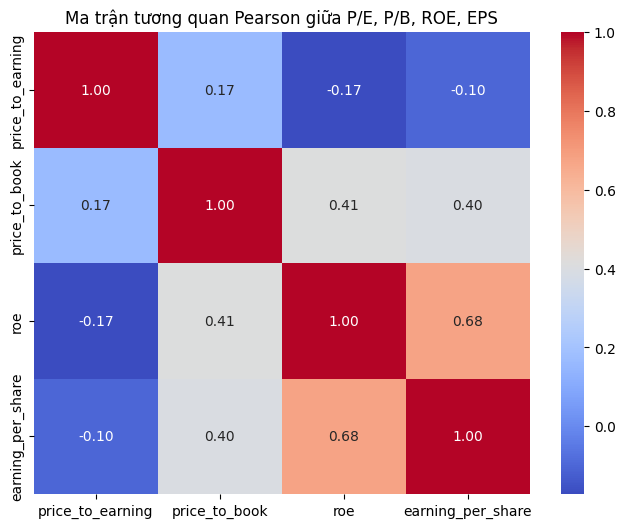


✅ Ma trận p-value (kiểm định ý nghĩa thống kê):
                   price_to_earning  price_to_book            roe  \
price_to_earning       1.000000e+00   1.208417e-07   3.915086e-08   
price_to_book          1.208417e-07   1.000000e+00   2.952686e-42   
roe                    3.915086e-08   2.952686e-42   1.000000e+00   
earning_per_share      1.457037e-03   1.704635e-39  8.917200e-136   

                   earning_per_share  
price_to_earning        1.457037e-03  
price_to_book           1.704635e-39  
roe                    8.917200e-136  
earning_per_share       1.000000e+00  


In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Chọn các cột cần phân tích
columns_of_interest = ['price_to_earning', 'price_to_book', 'roe', 'earning_per_share']
df_selected = df_combined[columns_of_interest].dropna()  # Loại bỏ dữ liệu bị thiếu

# Tính ma trận hệ số tương quan Pearson
correlation_matrix = df_selected.corr(method='pearson')

# Vẽ heatmap biểu diễn ma trận tương quan
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan Pearson giữa P/E, P/B, ROE, EPS")
plt.show()

# Tính p-value cho từng cặp biến
p_values = df_selected.corr(method=lambda x, y: stats.pearsonr(x, y)[1])  # Lấy p-value

print("\n✅ Ma trận p-value (kiểm định ý nghĩa thống kê):")
print(p_values)


📌 $\textbf{Kết luận}$
- Hệ số tương quan dương mạnh nhất:

    - ROE và EPS có tương quan mạnh (0.678, p-value ≈ 0), tức là ROE tăng thì EPS cũng có xu hướng tăng đáng kể.

    - P/B và ROE có tương quan dương khá cao (0.412, p-value ≈ 0), nghĩa là ROE cao thường đi kèm với giá trị sổ sách trên cổ phiếu cao hơn.

- Hệ số tương quan âm:
    - P/E và ROE có tương quan âm nhỏ (-0.173, p-value ≈ 0), cho thấy khi ROE tăng thì P/E có xu hướng giảm nhẹ (có thể do nhà đầu tư trả giá thấp hơn cho cổ phiếu có lợi nhuận cao).

- P-value rất nhỏ (<0.05) ở hầu hết các cặp, chứng tỏ các mối quan hệ đều có ý nghĩa thống kê.

👉 Tóm lại: EPS, ROE và P/B có mối tương quan đáng kể, trong khi P/E có tương quan yếu hơn với các tiêu chí khác.